In [1]:
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader # 없어도 되지만 빠르게 데이터를 불러오기 위해서 필요함
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
# 데이터 불러오기

train_path = 'data/'
train_root = os.path.join(train_path, "stage_2_train_images")  # train 이미지 경로

train_img_ids = os.listdir(train_root)

train_files, test_files = train_test_split(train_img_ids, test_size=0.2, random_state=55) # random_state 난수 생성 fix
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

print(f"총 이미지 개수: {len(train_img_ids)}")
print(f"Train 데이터 개수: {len(train_files)}")
print(f"Validation 데이터 개수: {len(val_files)}")
print(f"Test 데이터 개수: {len(test_files)}")

총 이미지 개수: 26684
Train 데이터 개수: 17077
Validation 데이터 개수: 4270
Test 데이터 개수: 5337


In [3]:
# image=label 매칭

df = pd.read_csv("data/stage_2_train_labels.csv")
df_grouped = df.groupby("patientId").agg({"Target": "first"}).reset_index() # 새로운 데이터 프레임 변환

train_df = df_grouped[df_grouped["patientId"].isin([f.split(".")[0] for f in train_files])]
val_df = df_grouped[df_grouped["patientId"].isin([f.split(".")[0] for f in val_files])]
test_df = df_grouped[df_grouped["patientId"].isin([f.split(".")[0] for f in test_files])]

df_grouped.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,000924cf-0f8d-42bd-9158-1af53881a557,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,1
3,000fe35a-2649-43d4-b027-e67796d412e0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1


In [4]:
# image.convert('RGB') 적용

import torchvision.transforms as transforms

imagenet_transform = transforms.Compose([
    transforms.Resize((224, 224)), # imageNet 모델 입력 크기기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # RGB 채널의 평균과 표준편차차
])

def load_dicom_image(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    image = dicom_data.pixel_array.astype("uint8")

    image = Image.fromarray(image).convert("RGB")

    image = imagenet_transform(image)

    return image

In [5]:
# dataset 생성 및 dataloader 준비

class PneumoniaDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir

    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dicom_path = os.path.join(self.img_dir, f"{row['patientId']}.dcm")

        image = load_dicom_image(dicom_path)
        label = torch.tensor(row["Target"], dtype=torch.long)

        return image, label

In [6]:
# dataloader 준비

train_dataset = PneumoniaDataset(train_df, train_root)
val_dataset = PneumoniaDataset(val_df, train_root)
test_dataset = PneumoniaDataset(test_df, train_root)

batch_size = 1

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(f"Train 데이터 개수: {len(train_dataset)}")
print(f"Validation 데이터 개수: {len(val_dataset)}")
print(f"Test  데이터 개수: {len(test_dataset)}")

Train 데이터 개수: 17077
Validation 데이터 개수: 4270
Test  데이터 개수: 5337


In [7]:
# dataset 체크

import pydicom
from PIL import Image

sample_image, sample_label = train_dataset[0]

print(f"Image Shape: {sample_image.shape}")
print(f"Label: {sample_label}")

Image Shape: torch.Size([3, 224, 224])
Label: 0


In [8]:
# dataloader 체크

batch = next(iter(train_loader))
batch_images, batch_labels = batch

print(f"Batch Image Shape: {batch_images.shape}")
print(f"Batch Labels: {batch_labels}")

Batch Image Shape: torch.Size([1, 3, 224, 224])
Batch Labels: tensor([0])


In [9]:
import os
import pydicom
import numpy as np
import cv2
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# CLAHE 적용하는 함수
def apply_CLAHE(image_array):
    """CLAHE(Contrast Limited Adaptive Histogram Equalization)를 적용하는 함수"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # CLAHE 생성
    image_clahe = clahe.apply(image_array)  # CLAHE 적용
    return image_clahe

def load_dicom_image(dicom_path):
    """DICOM 파일을 불러와 CLAHE를 적용한 후, PyTorch 텐서로 변환"""
    dicom_data = pydicom.dcmread(dicom_path)
    image = dicom_data.pixel_array

    # 데이터 타입 확인 후 변환 (uint8 필요)
    if image.dtype != np.uint8:
        image = (image / np.max(image) * 255).astype(np.uint8)

    # CLAHE 적용
    image = apply_CLAHE(image)

    # PIL Image 변환 및 RGB 변환
    image = Image.fromarray(image).convert("RGB")

    # torchvision transforms 적용
    imagenet_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 모델에 맞는 크기로 조정
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Mean, Std 적용
    ])
    
    image = imagenet_transform(image)

    return image

# Dataset 클래스에서 CLAHE 적용 추가
class PneumoniaDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dicom_path = os.path.join(self.img_dir, f"{row['patientId']}.dcm")

        # 수정: CLAHE가 적용된 DICOM 이미지 로드
        image = load_dicom_image(dicom_path)
        label = torch.tensor(row["Target"], dtype=torch.long)

        return image, label

# DataLoader 준비
batch_size = 64
train_dataset = PneumoniaDataset(train_df, train_root)
val_dataset = PneumoniaDataset(val_df, train_root)
test_dataset = PneumoniaDataset(test_df, train_root)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터셋 확인 (CLAHE 적용 후)
sample_image, sample_label = train_dataset[0]

print(f"Image Shape: {sample_image.shape}")
print(f"Label: {sample_label}")

Image Shape: torch.Size([3, 224, 224])
Label: 0


In [10]:
# 모델 선정

import torchvision.models as models
import torch.nn as nn
import torch
# import timm

# model = models.resnet50(pretrained=True)
# model = torch.create_model('efficientnet_b7', pretrained=True)
model = models.efficientnet_b5(pretrained=True)

# num_features = model.fc.in_features
# num_features = model.classifier.in_features
num_features = model.classifier[1].in_features
# model.classifier = nn.Linear(num_features, 1)
model.classifier[1] = nn.Linear(num_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

c:\ANACONDA\envs\smc\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ANACONDA\envs\smc\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to C:\Users\한다현/.cache\torch\hub\checkpoints\efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:16<00:00, 7.33MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [11]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss() # loss
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001) 
optimizer = optim.AdamW(model.parameters(), lr=0.000003)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
import numpy as np

# 학습 파라미터
num_epochs = 100  
best_val_loss = float('inf')  # 가장 낮은 Validation Loss 저장
early_stopping_patience = 10   # Early Stopping 기준 (연속 10 Epoch 동안 개선되지 않으면 학습 중단)
early_stopping_counter = 0    # Early Stopping 카운터

# Learning Rate Scheduler 
# factor = 0.1 (학습률 10배 감소)
# patience = 10 (10번 안에 loss가 감소하지 않으면)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}] start\n")  # Epoch 시작 

    # Train 
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Training", leave=False)

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float() # GPU로 데이터 이동, labels 차원 추가 (Binary Classification)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()  # Binary Classification 예측

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=loss.item())  # 실시간 손실 표시

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train  

    # Validation 단계
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_loader_tqdm = tqdm(val_loader, desc=f"Validation", leave=False)

    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predicted = (outputs > 0.5).float()

            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_loader_tqdm.set_postfix(loss=loss.item())  # 실시간 손실 표시

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val 

    # Learning Rate Scheduler 업데이트 (Validation Loss 기반)
    # scheduler.step(val_loss)
    scheduler.step() 

    # Checkpoint 저장 (Validation Loss가 개선될 경우만 저장)
    if val_loss < best_val_loss:
        best_val_loss = val_loss  # 최소 손실 갱신
        early_stopping_counter = 0  # Early Stopping 카운터 초기화
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'val_accuracy': val_accuracy
        }
        torch.save(checkpoint, "best_model_loss.pth")
        print(f"Best Model Saved! Epoch [{epoch+1}] | Val Loss: {val_loss:.4f}")

    else:
        early_stopping_counter += 1  # 개선되지 않으면 카운트 증가

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n")
    print("---------------------------------------------------------------")

    # Early Stopping 확인
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early Stopping at Epoch {epoch+1} | Best Val Loss: {best_val_loss:.4f}")
        break  # 학습 중단



Epoch [1/100] start



Best Model Saved! Epoch [1] | Val Loss: 0.6320
Epoch [1/100] - Train Loss: 0.6637, Train Acc: 77.53% | Val Loss: 0.6320, Val Acc: 77.52%

---------------------------------------------------------------

Epoch [2/100] start



Best Model Saved! Epoch [2] | Val Loss: 0.5658
Epoch [2/100] - Train Loss: 0.5960, Train Acc: 77.71% | Val Loss: 0.5658, Val Acc: 78.03%

---------------------------------------------------------------

Epoch [3/100] start



Best Model Saved! Epoch [3] | Val Loss: 0.4816
Epoch [3/100] - Train Loss: 0.5193, Train Acc: 78.94% | Val Loss: 0.4816, Val Acc: 80.16%

---------------------------------------------------------------

Epoch [4/100] start



Best Model Saved! Epoch [4] | Val Loss: 0.4349
Epoch [4/100] - Train Loss: 0.4560, Train Acc: 80.37% | Val Loss: 0.4349, Val Acc: 80.61%

---------------------------------------------------------------

Epoch [5/100] start



Best Model Saved! Epoch [5] | Val Loss: 0.4106
Epoch [5/100] - Train Loss: 0.4184, Train Acc: 80.48% | Val Loss: 0.4106, Val Acc: 81.48%

---------------------------------------------------------------

Epoch [6/100] start



Best Model Saved! Epoch [6] | Val Loss: 0.3969
Epoch [6/100] - Train Loss: 0.3941, Train Acc: 81.51% | Val Loss: 0.3969, Val Acc: 81.90%

---------------------------------------------------------------

Epoch [7/100] start



Best Model Saved! Epoch [7] | Val Loss: 0.3883
Epoch [7/100] - Train Loss: 0.3807, Train Acc: 81.89% | Val Loss: 0.3883, Val Acc: 82.13%

---------------------------------------------------------------

Epoch [8/100] start



Best Model Saved! Epoch [8] | Val Loss: 0.3857
Epoch [8/100] - Train Loss: 0.3673, Train Acc: 82.61% | Val Loss: 0.3857, Val Acc: 82.34%

---------------------------------------------------------------

Epoch [9/100] start



Best Model Saved! Epoch [9] | Val Loss: 0.3820
Epoch [9/100] - Train Loss: 0.3578, Train Acc: 82.92% | Val Loss: 0.3820, Val Acc: 82.53%

---------------------------------------------------------------

Epoch [10/100] start



Best Model Saved! Epoch [10] | Val Loss: 0.3798
Epoch [10/100] - Train Loss: 0.3490, Train Acc: 83.56% | Val Loss: 0.3798, Val Acc: 82.53%

---------------------------------------------------------------

Epoch [11/100] start



Best Model Saved! Epoch [11] | Val Loss: 0.3790
Epoch [11/100] - Train Loss: 0.3408, Train Acc: 83.96% | Val Loss: 0.3790, Val Acc: 82.51%

---------------------------------------------------------------

Epoch [12/100] start



Best Model Saved! Epoch [12] | Val Loss: 0.3780
Epoch [12/100] - Train Loss: 0.3347, Train Acc: 84.03% | Val Loss: 0.3780, Val Acc: 82.60%

---------------------------------------------------------------

Epoch [13/100] start



Best Model Saved! Epoch [13] | Val Loss: 0.3774
Epoch [13/100] - Train Loss: 0.3267, Train Acc: 84.74% | Val Loss: 0.3774, Val Acc: 82.65%

---------------------------------------------------------------

Epoch [14/100] start



Epoch [14/100] - Train Loss: 0.3203, Train Acc: 84.61% | Val Loss: 0.3777, Val Acc: 82.72%

---------------------------------------------------------------

Epoch [15/100] start



Epoch [15/100] - Train Loss: 0.3111, Train Acc: 85.21% | Val Loss: 0.3790, Val Acc: 82.74%

---------------------------------------------------------------

Epoch [16/100] start



Epoch [16/100] - Train Loss: 0.3028, Train Acc: 85.47% | Val Loss: 0.3804, Val Acc: 82.90%

---------------------------------------------------------------

Epoch [17/100] start



Epoch [17/100] - Train Loss: 0.2959, Train Acc: 85.93% | Val Loss: 0.3810, Val Acc: 83.14%

---------------------------------------------------------------

Epoch [18/100] start



Epoch [18/100] - Train Loss: 0.2861, Train Acc: 86.50% | Val Loss: 0.3830, Val Acc: 83.23%

---------------------------------------------------------------

Epoch [19/100] start



Epoch [19/100] - Train Loss: 0.2795, Train Acc: 86.82% | Val Loss: 0.3859, Val Acc: 83.16%

---------------------------------------------------------------

Epoch [20/100] start



Epoch [20/100] - Train Loss: 0.2699, Train Acc: 87.16% | Val Loss: 0.3889, Val Acc: 82.97%

---------------------------------------------------------------

Epoch [21/100] start



Epoch [21/100] - Train Loss: 0.2628, Train Acc: 87.36% | Val Loss: 0.3934, Val Acc: 82.83%

---------------------------------------------------------------

Epoch [22/100] start



Epoch [22/100] - Train Loss: 0.2498, Train Acc: 88.10% | Val Loss: 0.3979, Val Acc: 82.83%

---------------------------------------------------------------

Epoch [23/100] start



Epoch [23/100] - Train Loss: 0.2436, Train Acc: 88.51% | Val Loss: 0.4030, Val Acc: 83.00%

---------------------------------------------------------------
Early Stopping at Epoch 23 | Best Val Loss: 0.3774


c:\ANACONDA\envs\smc\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ANACONDA\envs\smc\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\한다현\AppData\Local\Temp\ipykernel_25800\2829577123.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S


Test Results - Loss: 0.3657, Accuracy: 83.94%
Sensitivity: 0.5718
Specificity: 0.9181
AUC: 0.8661


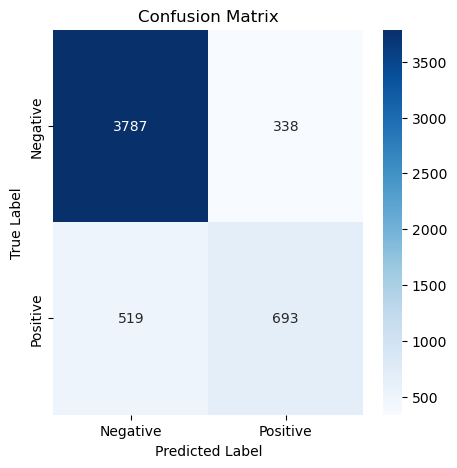

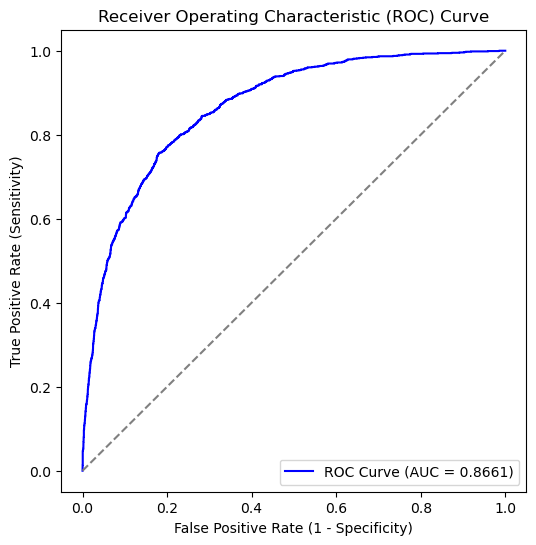

: 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torchvision.models as models

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 생성 (학습할 때 사용한 것과 동일하게 설정해야 함)
import timm  # timm 사용 시
# model = timm.create_model('efficientnet_b7', pretrained=False)  # pretrained=False

# # 모델의 마지막 레이어 수정 (학습 때와 동일해야 함)
# num_features = model.classifier.in_features
# model.classifier = nn.Linear(num_features, 1)
model = models.efficientnet_b5(pretrained=True)

# num_features = model.fc.in_features
# num_features = model.classifier.in_features
num_features = model.classifier[1].in_features
# model.classifier = nn.Linear(num_features, 1)
model.classifier[1] = nn.Linear(num_features, 1)

# 모델 가중치 로드
checkpoint = torch.load("best_model_loss.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()  # 모델을 평가 모드로 변경

# 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# 테스트 실행
test_loss = 0.0
correct_test = 0
total_test = 0

# 예측값 저장 리스트
all_labels = []
all_predictions = []
all_probabilities = []

test_loader_tqdm = tqdm(test_loader, desc=f"Testing", leave=False)

with torch.no_grad():  # 역전파 불필요
    for images, labels in test_loader_tqdm:
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()

        # 모델 예측
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        probabilities = torch.sigmoid(outputs)  # 로짓(logit)을 확률로 변환
        predicted = (probabilities > 0.5).float()  # Binary Classification (0.5 기준)

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        test_loader_tqdm.set_postfix(loss=loss.item())  # 실시간 손실 표시

        # 예측값 저장
        all_labels.extend(labels.cpu().numpy())  # 실제값
        all_predictions.extend(predicted.cpu().numpy())  # 예측값
        all_probabilities.extend(probabilities.cpu().numpy())  # 확률값

# 최종 결과 계산
test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

# Confusion Matrix 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)
TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity / Specificity 계산
sensitivity = TP / (TP + FN)  
specificity = TN / (TN + FP)  

# ROC Curve 계산
fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
roc_auc = auc(fpr, tpr)

# 최종 결과 출력
print(f"\nTest Results - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Confusion Matrix 시각화
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve 시각화
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')  # 대각선 기준선
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()